<a href="https://colab.research.google.com/github/JayThibs/Weak-Supervised-Learning-Case-Study/blob/main/text_classifier/notebooks/05_toxicity_classification_snorkel_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a Binary Classification Dataset of the Toxicity Dataset with Snorkel

In order to simplify the problem, we are going to turn this multi-label classification problem (does it contain any of these 'bad' labels?) to a binary classification problem (is it a 'bad' comment or not?).

We've already trained a multi-label model for this problem in notebook 01, so why are we doing this? We are doing this for a few reasons:

1. We want to test how well we can create labeling functions with Snorkel to build a dataset without knowing the labels.

2. It takes time to create many labeling functions that create a useful dataset, and it takes longer if it's for a multi-class classification problem, and even longer for multi-label classification. Therefore, in the interest of time, we will make the classification binary.

3. We want to try implementing Active Learning into our prototype and it will be simpler to start with a binary classification model.


Some of the code is borrowed from:

1. https://colab.research.google.com/drive/14Ea4lIzsn5EFvPpYKtWStXEByT9qmbkj?usp=sharing#scrollTo=acF4YRlQL8iz

2. https://www.inovex.de/blog/snorkel-weak-superversion-german-texts/

3. https://trishalaneeraj.github.io/2020-07-26/data-labeling-weak-supervision

In [1]:
!pip install snorkel --quiet
!pip install datasets --quiet
!pip install spacy --quiet

     |████████████████████████████████| 153kB 4.4MB/s 
     |████████████████████████████████| 1.8MB 31.0MB/s 
     |████████████████████████████████| 3.8MB 32.8MB/s 
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 225kB 4.5MB/s 
     |████████████████████████████████| 245kB 19.2MB/s 
     |████████████████████████████████| 112kB 22.1MB/s 


In [7]:
import pandas as pd
from snorkel.labeling import labeling_function
from datasets import load_dataset
from sklearn.model_selection import train_test_split

## Data

Our dataset contains potentially offensive (toxic) comments and comes from the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Let's start by download the data (from Google Drive):

In [3]:
!gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr

Downloading...
From: https://drive.google.com/uc?id=1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr
To: /content/toxic_comments.csv
68.8MB [00:00, 84.3MB/s]


We can take a look at the data:

In [5]:
# we can see 
df = pd.read_csv("toxic_comments.csv")
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


As we can see, we have comments from YouTube videos where most are clean comments, but there are some bad comments that are labeled as either: toxic,	severe_toxic,	obscene,	threat,	insult and/or	identity_hate. We will bunch them all together into the same label we will call 'toxic'.

## Preprocessing

Let's have a look at the dataset before we start creating labeling functions.

In [8]:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape

((151592, 8), (7979, 8))

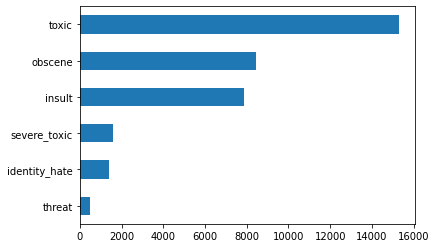

In [9]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

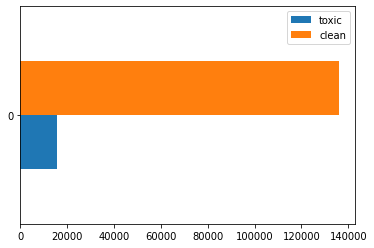

In [10]:
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(train_toxic)], 
  clean=[len(train_clean)]
)).plot(kind='barh');

The bad examples are imbalanced, but we will not worry about that. What we will do, however, is to eliminate clean examples from the dataset in order to make it more balanced.